In [175]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [195]:
import sys, os
sys.path.append("../..")
sys.path.append("..")
sys.path.append(os.getcwd())
import re
import datetime

from matplotlib import pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.dates as mdates
import seaborn as sns
sns.set()
sns.set(palette="bright")
sns.set_style("whitegrid")

from sklearn import linear_model
from cycler import cycler
from celluloid import Camera

from IPython.display import HTML

import importlib

#importlib.reload(some_module)
from syn_model import *
from filter_data import *


import warnings

import numpy as np
import pandas as pd
import copy
import random


from tslib.src import tsUtils
from tslib.tests import testdata

#warnings.filterwarnings(action='once')

from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation, DBSCAN #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering

import hdbscan
import plotly.figure_factory as ff
%matplotlib inline
import json

from scipy.stats import kstest

from sklearn.metrics import mean_squared_error
import math


In [177]:

#global settings for graphs        
cc = (cycler(linestyle=['-', '--', '-.',':']) * cycler(color=list('brgcmyk')))
plt.rc('lines', linewidth=2)
plt.rc('axes', prop_cycle=cc)
plt.rcParams.update({'font.size': 14})
plt.rcParams['figure.figsize'] = (8.0, 6.0)

plt.rcParams["animation.html"] = "html5"

In [178]:
from load_and_clean import *

#update_data()

us = load_clean('NYTimes US')
uscases, usdeaths, usstates = load_clean('NYTimes states')
uscounties_cases, uscounties_deaths, uscounties = load_clean('NYTimes counties')
global_cases, global_deaths = load_clean('JHU global')
us_covid_jhu_cases, us_covid_jhu_deaths = load_clean('JHU US')
mobility_data_apple, mobility_data_google, google_social = load_clean('mobility')
sd_data = load_clean('IHME intervention')
all_population, us_population, usstates_population, uscounties_population = load_clean('population')

uscases_pop_adjusted, usdeaths_pop_adjusted = create_population_adjusted_data(uscases, all_population, fast=True), \
                                    create_population_adjusted_data(usdeaths, all_population, show_exception = True, fast=True)
global_cases_pop_adjusted, global_deaths_pop_adjusted = create_population_adjusted_data(global_cases, all_population, fast=True), \
                                    create_population_adjusted_data(global_deaths, all_population, show_exception = True, fast=True)

uscounties_cases_pop_adjusted = create_population_adjusted_data(uscounties_cases, all_population, show_exception = True, county = True, fast=True)
uscounties_deaths_pop_adjusted = create_population_adjusted_data(uscounties_deaths, all_population, county = True, fast=True)

state_reopen = load_clean('state reopen')
#fips_df = pd.read_csv("../COVID/COVID-19/csse_covid_19_data/UID_ISO_FIPS_LookUp_Table.csv")

These countries/region do not have population data:  {'Virgin Islands'}
These countries/region do not have population data:  {'Canada-Nova Scotia', 'Canada-Northwest Territories', 'France-Saint Barthelemy', 'China-Shanghai', 'China-Tibet', 'China-Heilongjiang', 'France-Guadeloupe', 'Eswatini', 'China-Yunnan', 'Canada-Ontario', 'West Bank and Gaza', 'China-Gansu', 'China-Anhui', 'Netherlands-Bonaire, Sint Eustatius and Saba', 'Diamond Princess', 'Saint Kitts and Nevis', 'Canada-Newfoundland and Labrador', 'Cabo Verde', 'Netherlands-Aruba', 'Congo (Brazzaville)', 'China-Inner Mongolia', 'China-Henan', 'MS Zaandam', 'Australia-New South Wales', 'Netherlands-Curacao', 'China-Sichuan', 'Canada-Manitoba', 'Canada-Saskatchewan', 'Australia-Victoria', 'China-Qinghai', 'United Kingdom-Channel Islands', 'Australia-South Australia', 'Saint Vincent and the Grenadines', 'Syria', 'Canada-Repatriated Travellers', 'France-New Caledonia', 'China-Hong Kong', 'Canada-Diamond Princess', 'United Kingdom-Is

/Users/niloofarbayat/Documents/COVID19/synthetic control/COVID19-synthetic-control-analysis/synthetic_control_analysis/load_and_clean.py:229: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  county_population = pd.read_csv(_county_pop_local_path, header=[3], skipfooter=6)


In [179]:
#Filter data (this part might be overlapping some cells, but it should contain most of the varilables that are analyzed. )
# This part might be to split and explain
# This part might be to split and explain
t = 7
column = list(mobility_data_google.columns).index('retail_and_recreation_percent_change_from_baseline')
global_deaths_filtered = create_filtered_data(global_deaths, 500 )
#the last column of social distancing dataset is the last social distancing measure used by a location
educational_distancing = get_social_distancing(sd_data, sd_data.columns[-1])

all_data = pd.concat([global_deaths, usdeaths, uscounties_deaths], axis=1).dropna()
all_data_daily = create_rolling_data(all_data, t)

all_data_cases = pd.concat([global_cases, uscases, uscounties_cases], axis=1).dropna()
all_data_cases_daily = create_rolling_data(all_data_cases, t)

all_cases_data_pop = pd.concat([uscases_pop_adjusted,global_cases_pop_adjusted, uscounties_cases_pop_adjusted], axis = 1).dropna()
all_cases_data_pop_daily = create_rolling_data(all_cases_data_pop, t)

all_death_data_pop = pd.concat([usdeaths_pop_adjusted,global_deaths_pop_adjusted, uscounties_deaths_pop_adjusted], axis = 1).dropna()
all_death_data_pop_daily = create_rolling_data(all_death_data_pop, t)

_, daily_global, intervention_date_global = create_intervention_adjusted_data(global_deaths, educational_distancing, t)
_, daily_us, intervention_date_us = create_intervention_adjusted_data(usdeaths, educational_distancing, t)
_, daily_uscounties, intervention_date_uscounties = create_intervention_adjusted_data(uscounties_deaths, educational_distancing, t)

cases_intervention_adjusted, cases_intervention_adjusted_daily, intervention_date_case = create_intervention_adjusted_data(all_data_cases, educational_distancing, t)
deaths_intervention_adjusted, deaths_intervention_adjusted_daily, intervention_date_death = create_intervention_adjusted_data(all_data, educational_distancing, t)

all_cases_data_pop_adjusted, all_cases_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_cases_data_pop, educational_distancing, t)
all_death_data_pop_adjusted, all_death_data_pop_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, educational_distancing, t)


last date
Exceptions are []


In [180]:
masks_mandated = ['New York', 'Maine', 'Maryland', 'Virginia', 'New Mexico', 'California', 'Michigan', 'Illinois', 'Massachusetts','Delaware', 'Rhode Island']
masks_recommended = ['Montana', 'Idaho', 'Utah', 'Arizona', 'North Dakota', 'South Dakota', 'Kansas', 'Oklahoma', 
                     'Texas', 'North Carolina', 'South Carolina', 'West Virginia', 'Wisconsin','Iowa', 'Missouri', 'Alaska']
eu_countries = ['Austria', 'Belgium', 'Bulgaria', 'Croatia', 'Cyprus', 'Czechia', 'Denmark',
   'Estonia', 'Finland', 'France', 'Germany', 'Greece', 'Hungary', 'Ireland',
   'Italy', 'Latvia', 'Lithuania', 'Luxembourg', 'Malta', 'Netherlands',
   'Poland', 'Portugal', 'Romania', 'Slovenia', 'Spain', 'Sweden']

northeast = ["Connecticut","Maine","Massachusetts","New Hampshire",
             "Rhode Island","Vermont","New Jersey","New York",
             "Pennsylvania", "Delaware","District of Columbia","Maryland"]
midwest = ["Indiana","Illinois","Michigan","Ohio","Wisconsin",
             "Iowa","Kansas","Minnesota","Missouri","Nebraska",
             "North Dakota","South Dakota"]
south = ["Florida","Georgia",
            "North Carolina","South Carolina","Virginia",
            "West Virginia","Alabama","Kentucky","Mississippi",
            "Tennessee","Arkansas","Louisiana","Oklahoma","Texas"]

west= ["Arizona","Colorado","Idaho","New Mexico","Montana",
            "Utah","Nevada","Wyoming","Alaska","California",
            "Hawaii","Oregon","Washington"]

california_rollback = ["Fresno-California", "Imperial-California", "Kern-California", "Kings-California", "Los Angeles-California", "San Joaquin-California" , "Tulare-California",
                      "Riverside-California", "Sacramento-California", "San Bernardino-California", "Santa Barbara-California", "Santa Clara-California", "Contra Costa-California", "Stanislaus-California", 
                       "Ventura-California"]

google_counties = ['San Mateo-California', 'San Francisco-California', 'Santa Clara-California']

In [181]:
def _create_dir(path):
    if not os.path.exists(path):
        os.mkdir(path)
_create_dir("../data/vaccination")


_vaccine_state_web_path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/us_state_vaccinations.csv"
_vaccine_state_local_path = "../data/vaccination/us_state_vaccinations.csv"

_vaccine_global_web_path = "https://raw.githubusercontent.com/owid/covid-19-data/master/public/data/vaccinations/vaccinations.csv"
_vaccine_global_local_path = "../data/vaccination/vaccinations.csv"


def _update_vaccination_data(local_path = _vaccine_state_local_path, web_path = _vaccine_state_web_path):
    vaccine_hidden_path = "../data/vaccination/.us_vaccine.csv";
    return_value = os.system("curl -o %s -z %s %s" % (vaccine_hidden_path, vaccine_hidden_path, web_path))
    if return_value != 0:
        print("Unable to update vaccination data (%d)" % return_value, file=sys.stderr)
        return 1
    return_value_copy = os.system(powershell_path + "cp %s %s" % (vaccine_hidden_path, local_path))
    if return_value_copy != 0:
        print("Unable to update vaccination data (copy: %d)" % return_value_copy, file=sys.stderr)
        return 1
    return 0


def _import_vaccination_data(local_path = _vaccine_state_local_path):
    def interpolate_missing_vaccine(vaccine_data):
        cols = vaccine_data.columns
        vaccine_data[cols] = vaccine_data[cols].replace(0,np.nan)
        vaccine_data = vaccine_data.interpolate(method='linear', limit_direction='backward', axis=0)
        return vaccine_data
    
    regions = pd.read_csv(local_path)

    regions["location"].replace({"New York State": "New York"}, inplace=True)
    vaccine = regions.pivot(index='date', columns='location', values='people_vaccinated')
    full_vaccine = regions.pivot(index='date', columns='location', values='people_fully_vaccinated')

    # for region in regions:
    #     cases[region] = cases[regions[region]].sum(axis = 1)
    #     deaths[region] = deaths[regions[region]].sum(axis = 1)
    #vaccine = vaccine.fillna(0)
    #full_vaccine = full_vaccine.fillna(0)
    
    
    
    return interpolate_missing_vaccine(vaccine), interpolate_missing_vaccine(full_vaccine), regions

    
    '''
    vaccine_state = pd.read_csv(_NYTimes_local_path + "us_vaccine.csv")[1:]

    counties['county_state'] = counties['county']+'-'+counties['state']
    cases = counties.pivot_table(index='date', columns='county_state', values='cases')
    deaths = counties.pivot_table(index='date', columns='county_state', values='deaths')
    cases = cases.fillna(0)
    deaths = deaths.fillna(0)

    return cases, deaths, counties
    '''


# Global vaccination data

In [182]:
_update_vaccination_data(local_path = _vaccine_global_local_path, web_path = _vaccine_global_web_path)
vaccine, full_vaccine,_ = _import_vaccination_data(local_path = _vaccine_global_local_path)

vaccine_pop_adjusted, full_vaccine_pop_adjusted = create_population_adjusted_data(vaccine, all_population, fast=True), \
                                    create_population_adjusted_data(full_vaccine, all_population, show_exception = True, fast=True)


These countries/region do not have population data:  {'Faeroe Islands', 'Upper middle income', 'Palestine', 'Oceania', 'Slovakia', 'Cook Islands', 'Northern Ireland', 'Eswatini', 'High income', 'Taiwan', 'Saint Kitts and Nevis', 'British Virgin Islands', 'United States', 'Lower middle income', 'Pitcairn', 'Saint Helena', 'Tokelau', 'Timor', 'England', 'Niue', 'South Korea', 'Wallis and Futuna', 'Africa', 'Saint Vincent and the Grenadines', 'Jersey', 'Syria', 'Hong Kong', 'European Union', 'Wales', 'Northern Cyprus', 'Scotland', 'Macao', 'Anguilla', 'Congo', 'North Macedonia', "Cote d'Ivoire", 'North America', 'Kyrgyzstan', 'Europe', 'Bonaire Sint Eustatius and Saba', 'Gambia', 'Guernsey', 'World', 'Asia', 'Saint Lucia', 'South America', 'Low income', 'Falkland Islands', 'Montserrat', 'Bahamas'}


In [183]:
df1, df2 = full_vaccine_pop_adjusted, all_cases_data_pop_daily
df1 = df1.reindex(df2.index, fill_value=0)


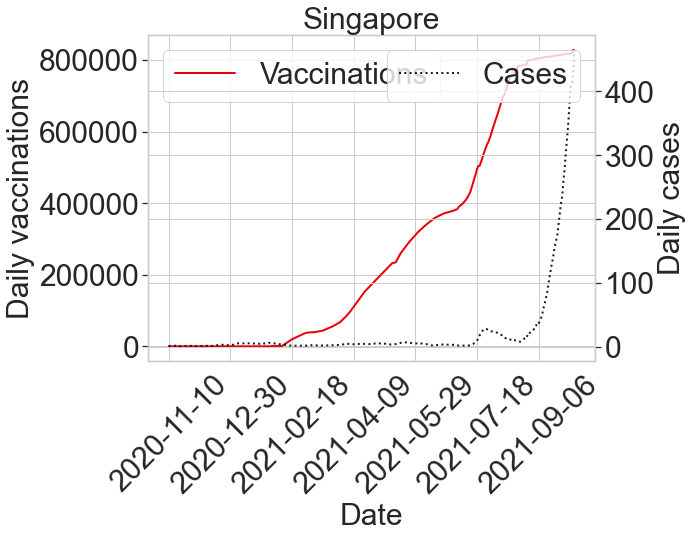

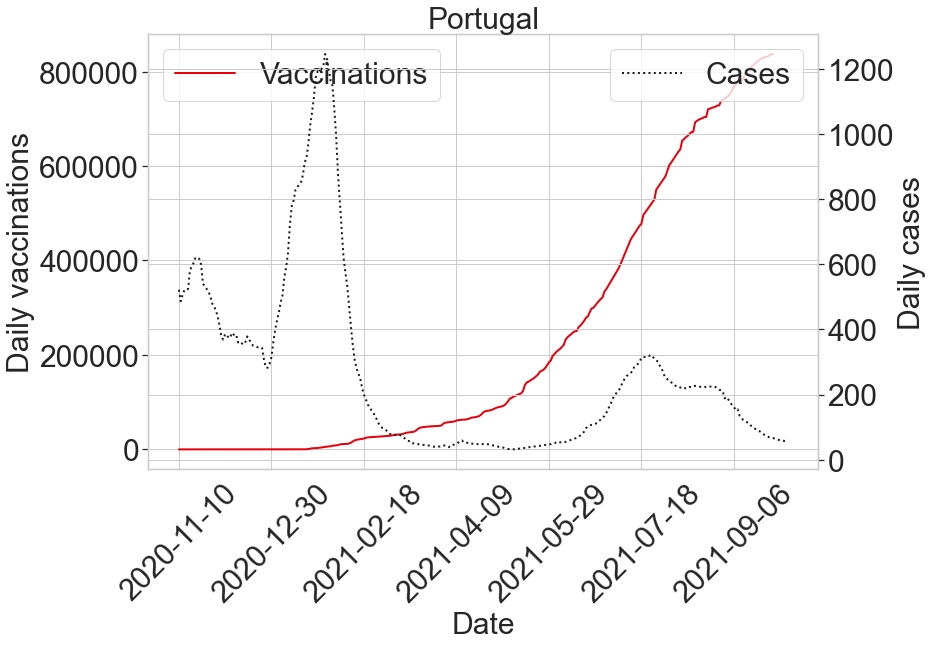

In [184]:
for target in ['Singapore', 'Portugal']:
    fig, ax = plt.subplots()

    plt.rcParams['figure.figsize'] = (12.0, 8.0)




    FONTSIZE = 30

    df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
    #plt.legend()
    plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
    plt.yticks(fontsize = FONTSIZE)
    plt.legend(fontsize = FONTSIZE , loc = 'upper left')
    plt.xticks(fontsize = FONTSIZE)
    plt.xticks(rotation=45)
    #ax.axes.xaxis.set_ticklabels([])


    ax2 = ax.twinx()
    ax2.set_ylabel('Cases')
    df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
    #plt.legend()
    plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

    plt.legend(fontsize = FONTSIZE , loc = 'upper right')
    plt.yticks(fontsize = FONTSIZE)
    #plt.xticks(fontsize = FONTSIZE)
    #ax2.axes.xaxis.set_ticklabels([])

    #plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')
    plt.title(target, fontsize = FONTSIZE)

    plt.show()

In [185]:
donors  = ['Italy', 'United Kingdom', 'France', 'Spain', 'Germany', 'Netherlands', 'Belgium', 'Switzerland']

total = full_vaccine_pop_adjusted
total = total[set(global_cases.columns).intersection(set(total.columns))]
vaccine_intervention = pd.DataFrame(total.apply(pd.Series.first_valid_index))
vaccine_intervention = vaccine_intervention.reset_index()
vaccine_intervention.columns = ["name", "date"]


case_vaccine_adjusted, case_vaccine_adjusted_daily, vaccine_date_case= create_intervention_adjusted_data(all_cases_data_pop, vaccine_intervention, 7, ignore_nan=False)
deaths_vaccine_adjusted, deaths_vaccine_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, vaccine_intervention, 7)
vaccine_adjusted, vaccine_adjusted_daily, vaccine_date = create_intervention_adjusted_data(df1, vaccine_intervention, 7, ignore_nan=False)



In [186]:
immune_per_million = case_vaccine_adjusted.add(vaccine_adjusted)

In [187]:
immune_per_million

,Afghanistan,Albania,Algeria,Andorra,Angola,Antigua and Barbuda,Argentina,Armenia,Australia,Austria,...,United Arab Emirates,United Kingdom,Uruguay,Uzbekistan,Vanuatu,Venezuela,Vietnam,Yemen,Zambia,Zimbabwe
0,3139.649373,13503.892298,20394.126341,112979.438934,2215.892319,29656.494369,33096.992164,48961.266019,18679.317236,33155.043823,...,45883.007281,31233.346954,6781.765118,6075.496414,434.532896,8181.699914,117.312478,397.060027,1157.924364,667.125945
1,3146.382332,13747.907269,20417.622227,113717.310176,2218.609931,29678.276591,33270.496609,49380.126400,18679.990037,33616.309577,...,46023.337650,31481.588263,6840.339147,6077.381428,434.532896,8196.037024,117.388810,397.060027,1160.083290,667.125945
2,3154.468031,14018.573520,20438.874407,114597.079733,2220.288455,29678.276591,33446.212182,49803.294682,18680.410538,34077.226943,...,46167.162628,31709.994831,6907.364154,6080.448569,434.532896,8211.499243,117.421525,397.060027,1161.933798,686.032867
3,3163.014892,14295.816060,20459.118180,115320.761143,2225.563818,29678.276591,33605.113970,50195.644912,18680.704889,34520.260390,...,46310.332367,31960.201192,6987.794163,6090.672375,434.532896,8222.075272,117.421525,397.060027,1169.767614,693.916092
4,3167.011626,14588.634025,20478.580437,116030.252721,2227.282308,29678.276591,33724.906433,50615.499425,18681.083340,34920.209850,...,46442.909074,32198.755410,7055.984823,6090.672375,434.532896,8231.719068,117.465143,397.060027,1172.296641,698.402480
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
304,NaN,336197.596055,NaN,NaN,NaN,502300.747130,635574.837410,NaN,491185.357625,717034.711525,...,984465.919541,810242.224566,862894.518666,NaN,80559.160169,NaN,119124.125718,NaN,38588.329082,155175.327735
305,NaN,338072.184820,NaN,NaN,NaN,505260.406456,641436.007827,NaN,496246.589055,717754.481199,...,986111.825504,811221.373033,862975.531501,NaN,83193.617063,NaN,123065.718105,NaN,39202.080810,156022.614217
306,NaN,339331.890472,NaN,NaN,NaN,NaN,645330.126584,NaN,499566.484726,718144.443536,...,987749.868597,812007.363049,863021.574767,NaN,85828.073956,NaN,127393.924788,NaN,NaN,156663.847292
307,NaN,340429.957839,NaN,NaN,NaN,NaN,648262.381654,NaN,503957.311771,718789.542042,...,989898.506743,812983.640698,865729.676488,NaN,88462.530849,NaN,135521.952198,NaN,NaN,157338.407823


target model rank estimation failed, rank 2 ued by default


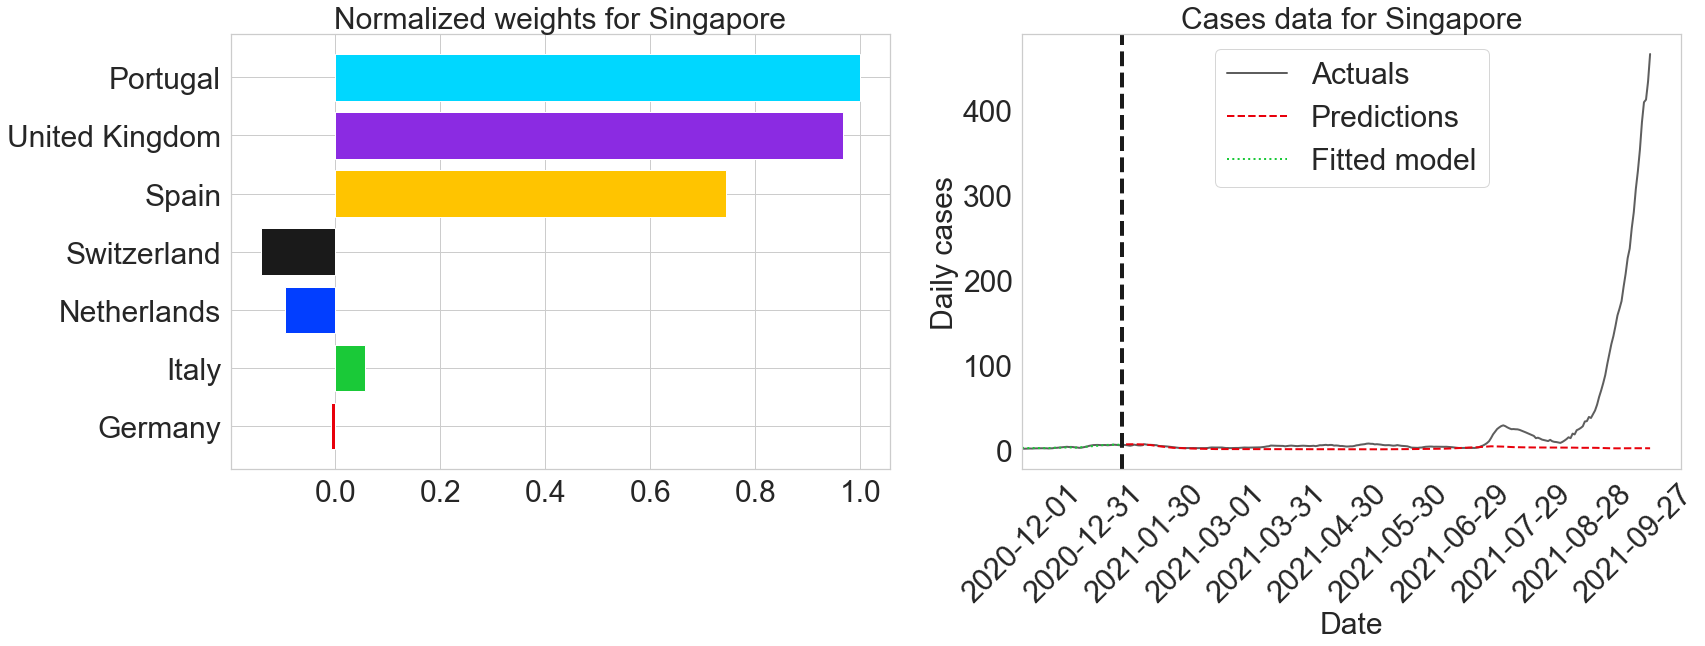

In [192]:
target = 'Singapore'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
rscModel = syn_model(target, singVals, [case_vaccine_adjusted_daily, case_vaccine_adjusted, immune_per_million], projection_period, training_period, otherStates=donors+['Portugal'])

# to ensure there aren't too few donors
fig, axes = plt.subplots(1, 2, figsize = (26, 8))
try:
    rscModel.fit_model(filter_donor = True, filter_method = 'combine', singVals_estimate = True, singval_mathod = "auto")
    print(rscModel.donors)
    print('target rank estimation: ', rscModel.kSingularValues)
except:
    rscModel.fit_model(filter_donor = True, filter_method = 'combine')
    print('target model rank estimation failed, rank 2 ued by default')


rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=True, tick_spacing=30, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=vaccine_date_case, fontsize = FONTSIZE)



In [197]:
def find_auto_rank(input_df, intervention,nominal_rank, start = 1):
    nlags = 10
    valid_sv = {}

    for i in range(start,nominal_rank+1):
        m = syn_model(0, i, [input_df], 200, intervention, otherStates=list(input_df.columns)[1:])
        m.fit_model(force_positive=False)
        err = (m.denoisedDF.values - m.train.values)
        #valid_sv.append([])
        for j in range(len(err[0])):
            error = np.array([err[i][j] for i in range(len(err))])
            error = (error - error.mean()) / error.std()

            lag_acf, confint, q_stat, p_values = acf(error, nlags=nlags, alpha=.05, qstat = True)
            lag_pacf, confint = pacf(error, nlags=nlags, alpha=.05)
            if ((p_values>0.05).all() or i == nominal_rank) and j not in valid_sv: #(p_values.mean()>0.05): #
                valid_sv[j]= i
     
    valid_sv = list(valid_sv.values())
    if len(valid_sv):
        return round((np.array(valid_sv)).mean())
    return 0 #nominal_rank

In [200]:
rscModel = syn_model(target, singVals, [case_vaccine_adjusted_daily, case_vaccine_adjusted, immune_per_million], projection_period, training_period, otherStates=donors+['Singapore'])

rscModel.fit_model(filter_donor = True, filter_method = 'combine')
input_df = rscModel.train
intervention = rscModel.low_thresh
nominal_rank = min(np.array(input_df).shape)

print(intervention,nominal_rank)

find_auto_rank(input_df, intervention,nominal_rank, start = 1)


50 8


KeyError: 0

0
target model rank estimation failed, rank 2 ued by default


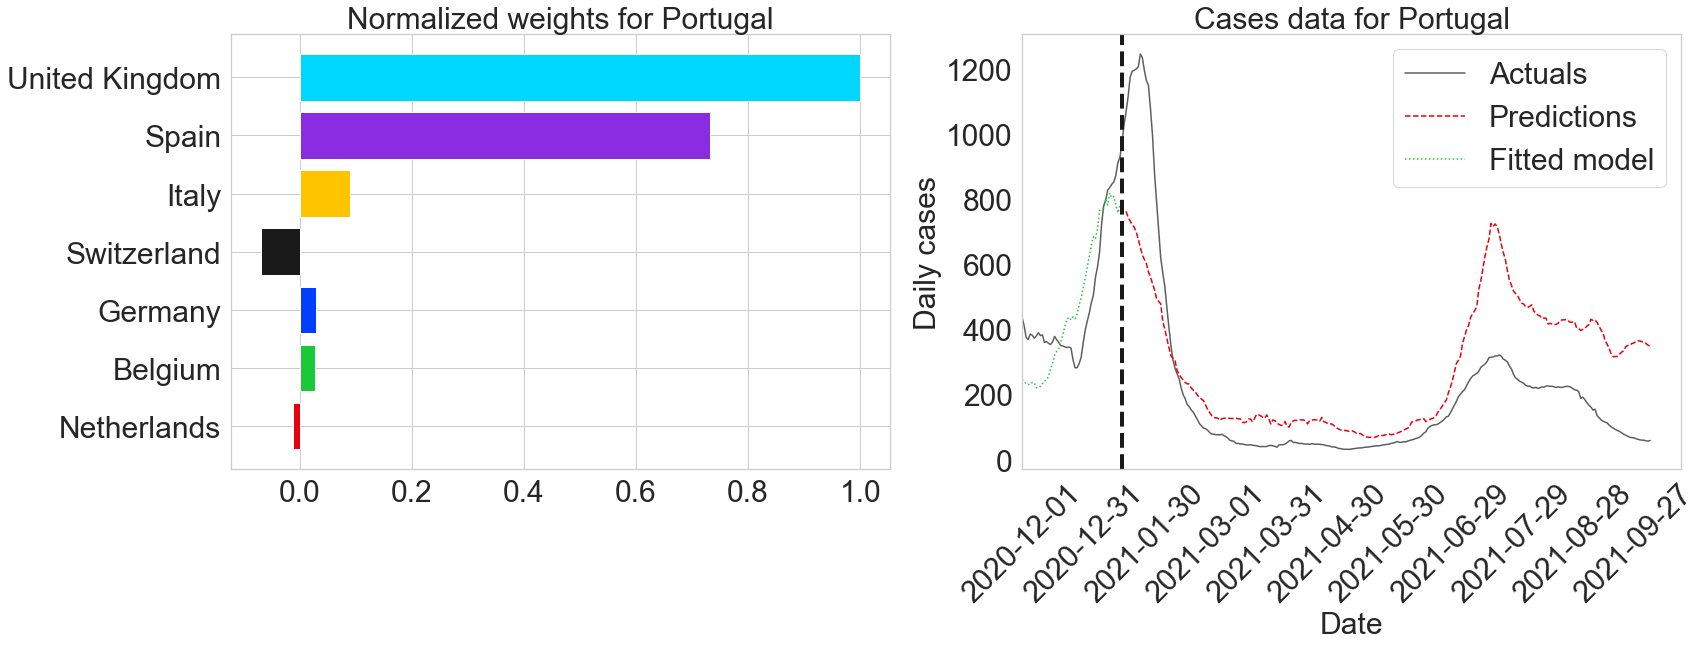

In [196]:
target = 'Portugal'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
rscModel = syn_model(target, singVals, [case_vaccine_adjusted_daily, case_vaccine_adjusted, immune_per_million], projection_period, training_period, otherStates=donors+['Singapore'])

# to ensure there aren't too few donors
fig, axes = plt.subplots(1, 2, figsize = (26, 8))

try:
    rscModel.fit_model(filter_donor = True, filter_method = 'combine', singVals_estimate = True, singval_mathod = "auto")
    print('target rank estimation: ', rscModel.kSingularValues)
except Exception as e:
    print(e)
    rscModel.fit_model(filter_donor = True, filter_method = 'combine')
    print('target model rank estimation failed, rank 2 ued by default')


rscModel.plot(figure=fig, axes=axes, title_text="Cases data", ylimit=[], xlimit=[], logy=False, show_donors=True, tick_spacing=30, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=vaccine_date_case, fontsize = FONTSIZE)



# US States

In [ ]:
_update_vaccination_data()
vaccine, full_vaccine,_ = _import_vaccination_data()

vaccine_pop_adjusted, full_vaccine_pop_adjusted = create_population_adjusted_data(vaccine, all_population, fast=True), \
                                    create_population_adjusted_data(full_vaccine, all_population, show_exception = True, fast=True)


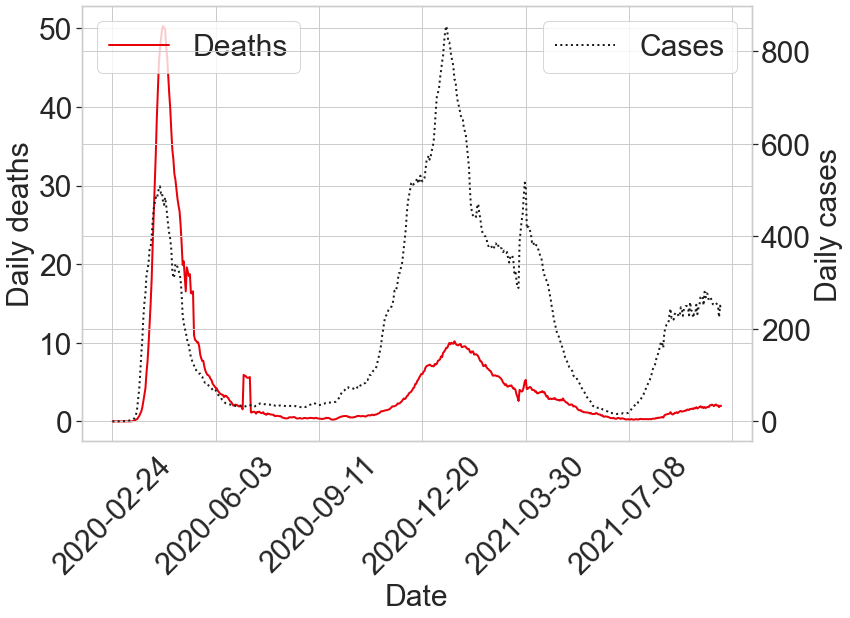

In [27]:
fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (12.0, 8.0)


target ='New York'

FONTSIZE = 30

all_death_data_pop_daily[target].iloc[25:].plot(ax = ax, color='r', label='Deaths')
#plt.legend()
plt.ylabel('Daily deaths', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
all_cases_data_pop_daily[target].iloc[25:].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

plt.show()

In [14]:
total = full_vaccine_pop_adjusted
total = total[set(uscases.columns).intersection(set(total.columns))]
vaccine_intervention = pd.DataFrame(total.apply(pd.Series.first_valid_index))
vaccine_intervention = vaccine_intervention.reset_index()
vaccine_intervention.columns = ["name", "date"]
total = total.fillna(0)
donors = full_vaccine_pop_adjusted.tail(1)[full_vaccine_pop_adjusted.tail(1)>630000].dropna(axis = 1).columns.tolist()


In [28]:
df1, df2 = full_vaccine_pop_adjusted, all_cases_data_pop_daily
df1 = df1.reindex(df2.index, fill_value=0)

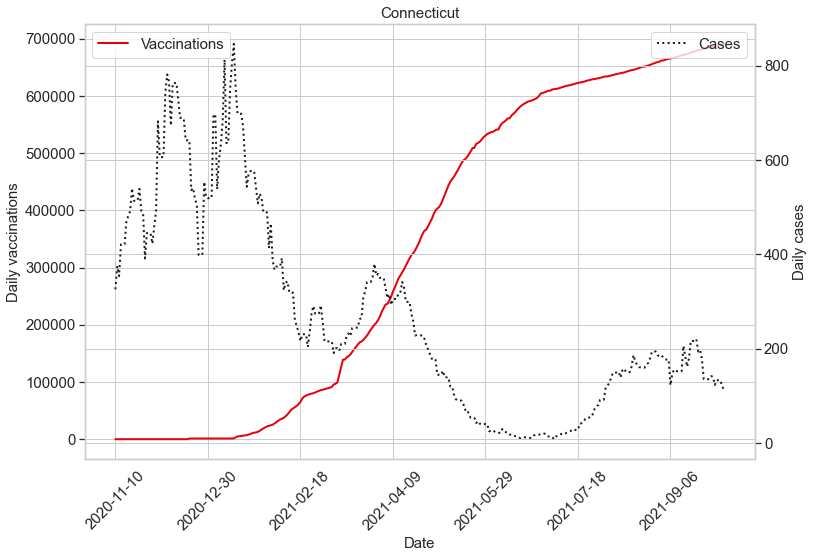

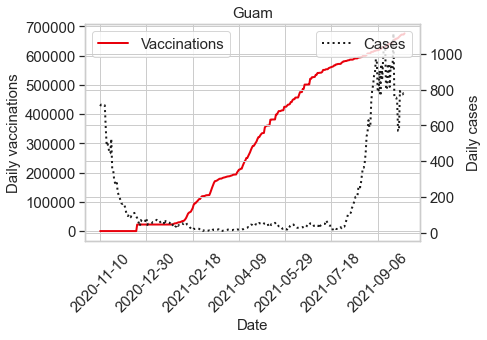

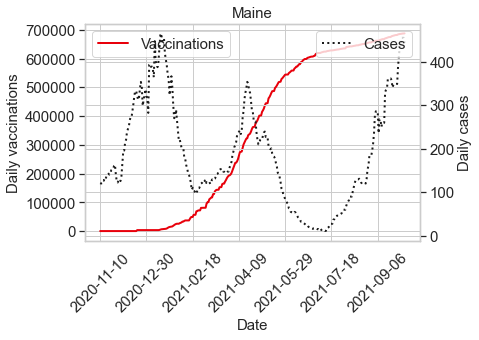

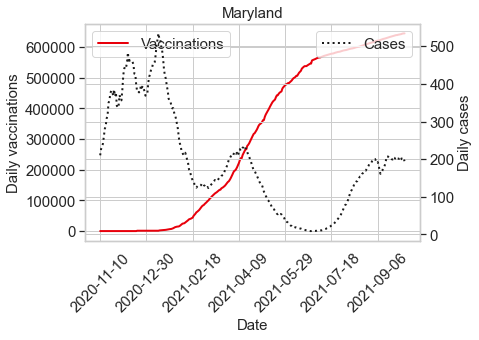

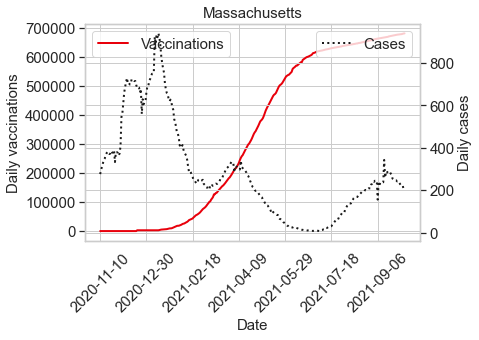

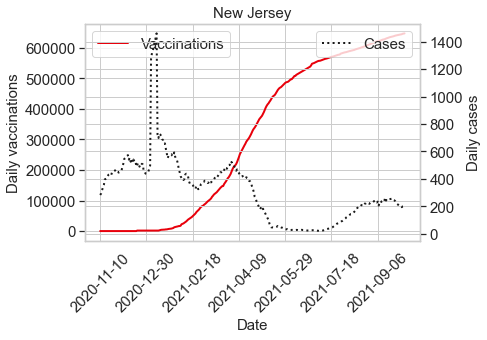

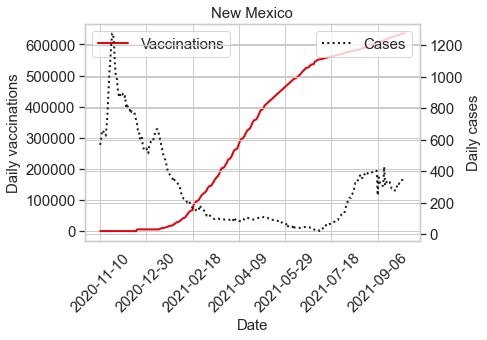

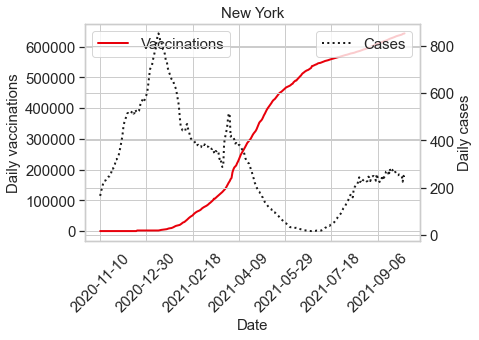

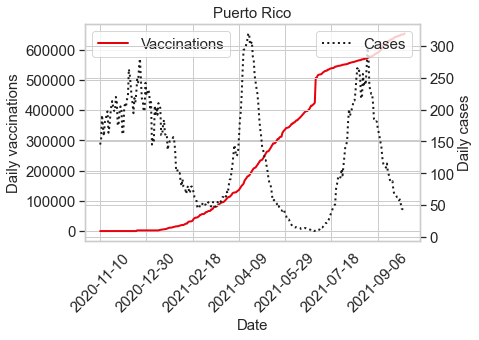

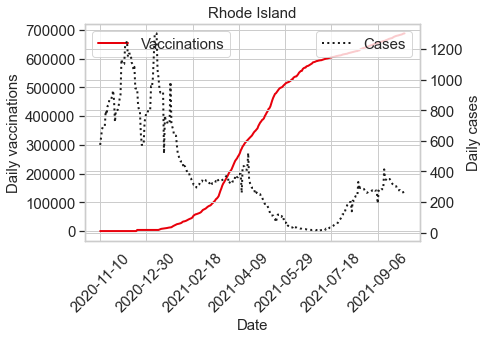

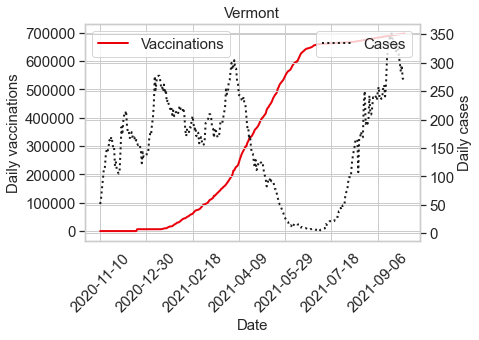

In [15]:
for target in donors:

    fig, ax = plt.subplots()

    plt.rcParams['figure.figsize'] = (6.0, 4.0)

    FONTSIZE = 15

    df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
    #plt.legend()
    plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
    plt.yticks(fontsize = FONTSIZE)
    plt.legend(fontsize = FONTSIZE , loc = 'upper left')
    plt.xticks(fontsize = FONTSIZE)
    plt.xticks(rotation=45)
    #ax.axes.xaxis.set_ticklabels([])


    ax2 = ax.twinx()
    ax2.set_ylabel('Cases')
    df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
    #plt.legend()
    plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

    plt.legend(fontsize = FONTSIZE , loc = 'upper right')
    plt.yticks(fontsize = FONTSIZE)
    #plt.xticks(fontsize = FONTSIZE)
    #ax2.axes.xaxis.set_ticklabels([])
    plt.title(target, fontsize = FONTSIZE)
    #plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')

    plt.show()


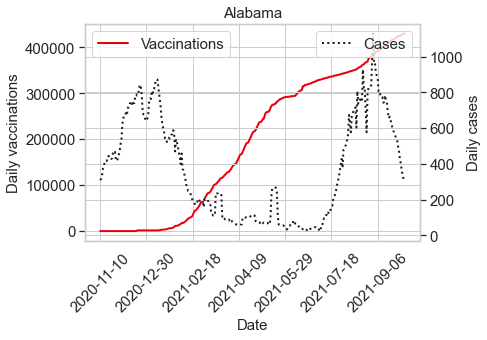

In [16]:

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6.0, 4.0)


target ='Alabama'

FONTSIZE = 15

df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')
plt.title(target, fontsize = FONTSIZE)

plt.show()

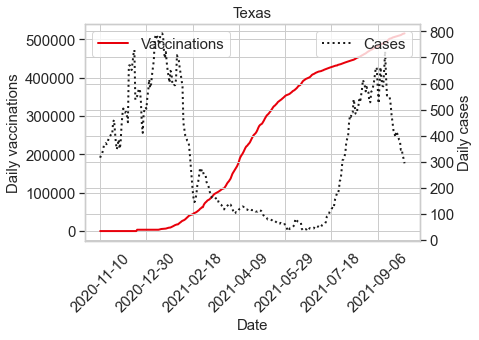

In [17]:

fig, ax = plt.subplots()

plt.rcParams['figure.figsize'] = (6.0, 4.0)


target ='Texas'

FONTSIZE = 15

df1[target].loc['2020-11-1':].plot(ax = ax, color='r', label='Vaccinations')
#plt.legend()
plt.ylabel('Daily vaccinations', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)
plt.yticks(fontsize = FONTSIZE)
plt.legend(fontsize = FONTSIZE , loc = 'upper left')
plt.xticks(fontsize = FONTSIZE)
plt.xticks(rotation=45)
#ax.axes.xaxis.set_ticklabels([])


ax2 = ax.twinx()
ax2.set_ylabel('Cases')
df2[target].loc['2020-11-1':].plot(ax = ax2, secondary_y=True, color='k',linestyle=":", label='Cases')
#plt.legend()
plt.ylabel('Daily cases', fontsize = FONTSIZE ), plt.xlabel('Date',fontsize = FONTSIZE)

plt.legend(fontsize = FONTSIZE , loc = 'upper right')
plt.yticks(fontsize = FONTSIZE)
#plt.xticks(fontsize = FONTSIZE)
#ax2.axes.xaxis.set_ticklabels([])

#plt.savefig('../Figures/COVID/'+target+'_deaths_cases.pdf', bbox_inches='tight')
plt.title(target, fontsize = FONTSIZE)

plt.show()

# Counterfactual analysis

In [18]:
full_vaccine_pop_adjusted.tail(1)

,Alabama,Alaska,American Samoa,Arizona,Arkansas,California,Colorado,Connecticut,Delaware,District of Columbia,...,South Dakota,Tennessee,Texas,Utah,Vermont,Virginia,Washington,West Virginia,Wisconsin,Wyoming
date,,,,,,,,,,,,,,,,,,,,,
2021-10-05,430725.130706,509282.409148,517915.661349,514789.625699,459916.217223,594304.501673,597796.634539,691302.832002,579064.331809,604882.188994,...,519429.520301,459322.752649,515874.927201,512495.484969,697523.514036,610371.6716,615306.872992,405349.003179,567948.902469,420195.625468


In [19]:

case_vaccine_adjusted, case_vaccine_adjusted_daily, vaccine_date_case= create_intervention_adjusted_data(all_cases_data_pop, vaccine_intervention, 7, ignore_nan=False)
deaths_vaccine_adjusted, deaths_vaccine_adjusted_daily, _ = create_intervention_adjusted_data(all_death_data_pop, vaccine_intervention, 7)
vaccine_adjusted, vaccine_adjusted_daily, vaccine_date = create_intervention_adjusted_data(df1, vaccine_intervention, 7, ignore_nan=False)



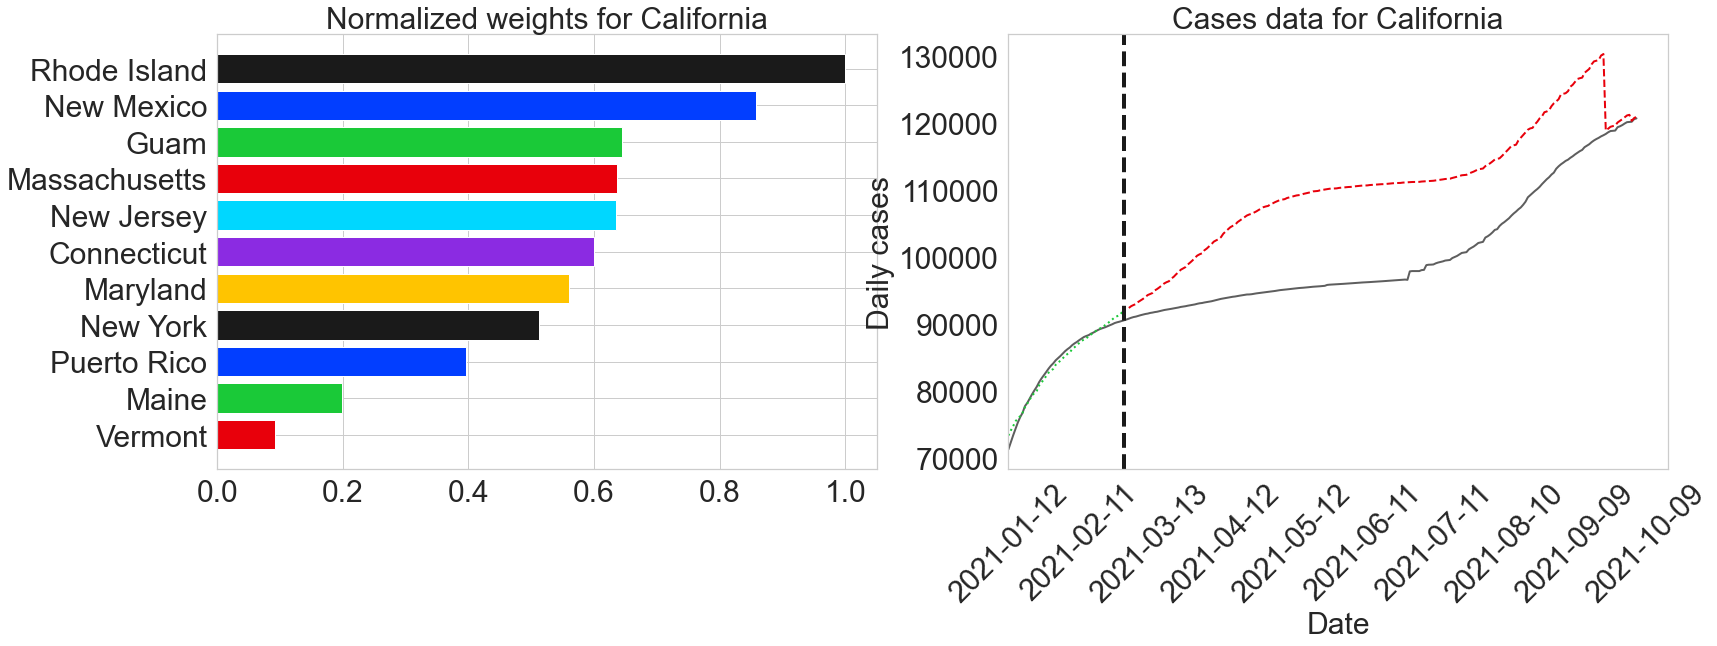

In [20]:

target = 'California'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([case_vaccine_adjusted, vaccine_adjusted],projection_period, training_period, #, xlimit=(1,200)
                                            "Cases data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = vaccine_date_case)



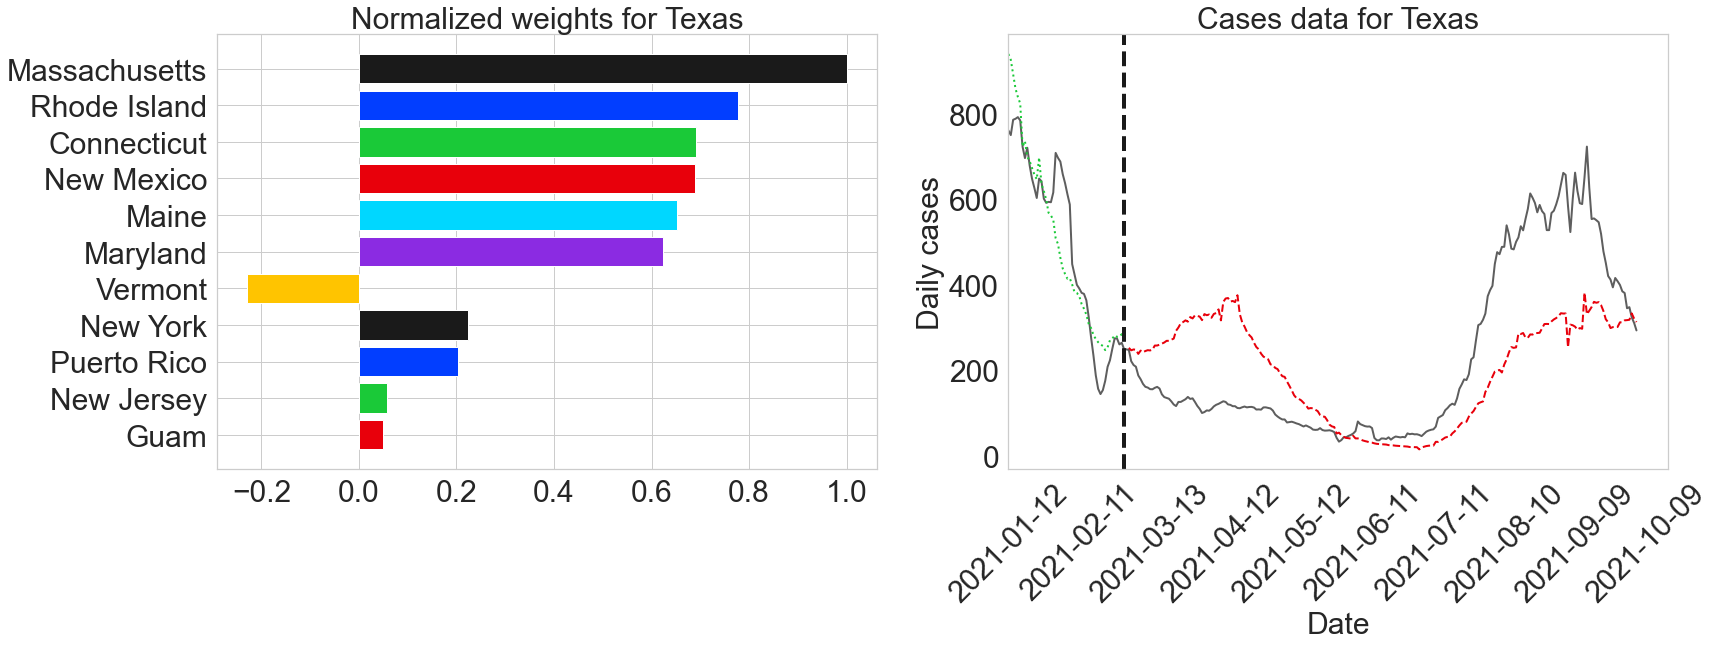

In [21]:

target = 'Texas'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([case_vaccine_adjusted_daily, deaths_vaccine_adjusted_daily],projection_period, training_period, #, xlimit=(1,200)
                                            "Cases data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = vaccine_date_case)



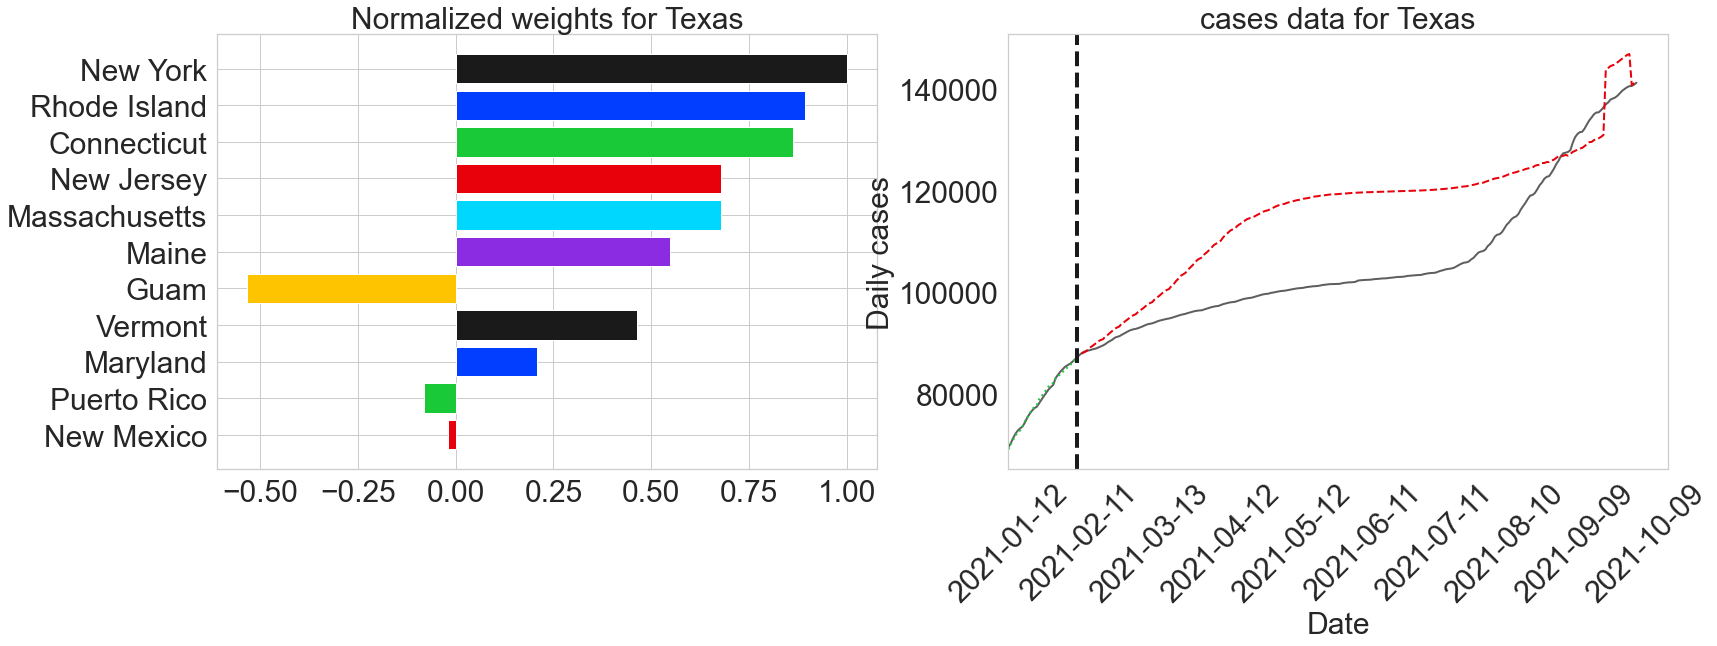

In [22]:

target = 'Texas'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 3
lambdas = [1]
projection_period=400
training_period=30
fig, axes = plt.subplots(1, 2, figsize=(26,8))

newdata = synth_control_predictions([case_vaccine_adjusted, vaccine_adjusted],projection_period, training_period, #, xlimit=(1,200)
                                            "cases data", singVals, ylimit=[], savePlots=False, do_only=[target], showstates=10,
                               exclude=[target], figure=fig, axes=axes, donorPool=donors, 
                                    svdSpectrum=False, silent=True, showDonors=True, showPlots=True, lambdas=lambdas, mRSC=False, error_thresh=178463, FONTSIZE=30, yaxis = 'Daily cases', intervention_date_x_ticks = vaccine_date_case)



1
target rank estimation:  1


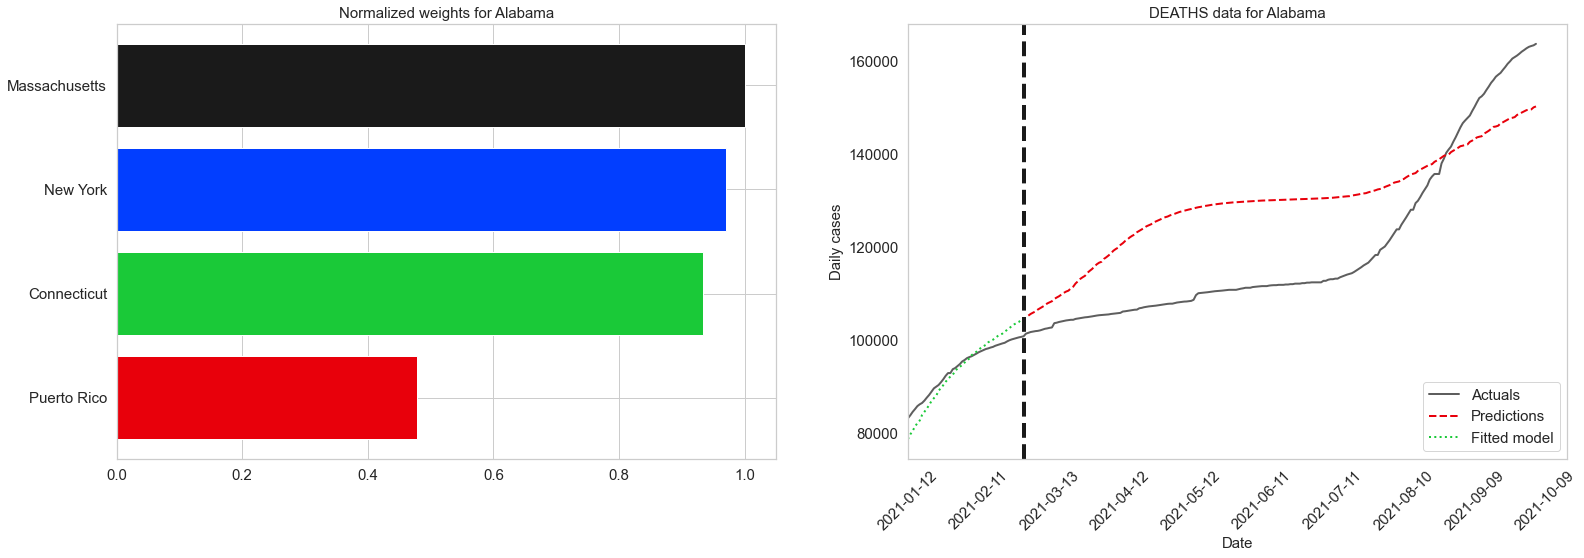

In [23]:
target = 'Alabama'# 'Italy', 'Spain', 'United Kingdom', 'France']
singVals = 2
lambdas = [1]
projection_period=400
training_period=50
rscModel = syn_model(target, singVals, [case_vaccine_adjusted, vaccine_adjusted], projection_period, training_period, otherStates=donors)

# to ensure there aren't too few donors
fig, axes = plt.subplots(1, 2, figsize = (26, 8))

try:
    rscModel.fit_model(filter_donor = True, filter_method = 'bin', singVals_estimate = True)
    print('target rank estimation: ', rscModel.kSingularValues)
except:
    rscModel.fit_model(filter_donor = True, filter_method = 'bin')
    print('target model rank estimation failed, rank 2 ued by default')


rscModel.plot(figure=fig, axes=axes, title_text="DEATHS data", ylimit=[], xlimit=[], logy=False, show_donors=True, tick_spacing=30, xaxis="Date", yaxis="Daily cases", intervention_date_x_ticks=vaccine_date_case, fontsize = FONTSIZE)

